# Notebook Summary

The aim of this project is to use features in the dataset to determine the dynamic price of taxi services in the US. The models predict the price of the cab services at a particular point of time using multiple parameters.

Libraries used are: pandas, numpy, matplotlib, seaborn, nltk, string, sklearn, math.

Explanation:
1. The dataset originally has 693071 rows and 57 columns with combination of float, int and string data types for features.
2. The target variable is 'price'. Since the model is regression based the values are continuous and represent the price of the cab service.
3. The columns in the dataset are 'id', 'timestamp', 'hour', 'day', 'month', 'datetime', 'timezone', 'source', 'destination', 'cab_type', 'product_id', 'name', 'price','distance', 'surge_multiplier', 'latitude', 'longitude', 'temperature','apparentTemperature', 'short_summary', 'long_summary','precipIntensity', 'precipProbability', 'humidity', 'windSpeed', 'windGust', 'windGustTime', 'visibility', 'temperatureHigh', 'temperatureHighTime', 'temperatureLow', 'temperatureLowTime', 'apparentTemperatureHigh', 'apparentTemperatureHighTime', 'apparentTemperatureLow', 'apparentTemperatureLowTime', 'icon', 'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex', 'visibility.1', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase', 'precipIntensityMax', 'uvIndexTime', 'temperatureMin', 'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime', 'apparentTemperatureMin', 'apparentTemperatureMinTime', 'apparentTemperatureMax', 'apparentTemperatureMaxTime'.
4. The current time stamp is used to find the absolute difference between other time stamps. The interaction effect of the time stamp difference and the values are taken. The interaction terms represent the time difference and the effect of tha feature on current cab prices.
5. Natural language processing techniques are used for long and short summary of the day for creating column dummies.
6. The correlation is found between actual vs apparent columns and for those columns with correlation above 0.9 are dropped.
7. All the columns with extremely high correlations are dropped.
8. The pandas get dummies is used for getting dummy for categories.
9. Since some columns require scaling, two scaling techniques are used StandardScaler and MinMaxScaler. StandardScaler is used for the columns with ditribution similar to normal and where outliers are less. MinMaxScaler is used for the columns which are much more flat, have less outliers and follow no specific pattern for distribution.
10. All the NaN values after scaling the dataset are dropped.
11. The train_test_split of sklearn is used to generate the train and test datasets.
12. Mean squared error metric is used as the parameter to judge multiple models.
13. After train and test split the X_train has 8000 rows and 41 columns, y_train has 8000 rows, X_test has 2000 rows and 41 columns and y_test has 2000 columns. (This dataset is a small sample of the previous dataset because of computational differences)
14. The models trained are:
* Linear Regression (All columns with nearly 0 coefficients are droppped now)
* Regression with bagging and base estimators:
    ** Decision Tree with maximum depth 8
    ** Lasso regression with alpha 0.01
* Regression with pasting and base estimators:
    ** Decision Tree with maximum depth 8
    ** Lasso regression with alpha 0.01
* Adaboost with base estimators:
    ** Decision Tree with maximum depth 8
    ** Lasso regression with alpha 0.01
* Gradientboost with number of estimators in [1,2,5,10,25]
* PCA: Dataset is reduced to keep the explained variance equal to 95%. The features drop to 27 from 41. All the above models are trained on the reduced dataset.
* MLP classifier on grid search CV with parameters in dictionary {'activation':['tanh', 'relu'],'solver':['lbfgs', 'sgd', 'adam'],'alpha':[0.001,0.01,0.1]}. The model is trained on both original and reduced dataset.

###### Multi layer perceptron with activation 'tanh', alpha 0.001, and optimizer 'adam' has the lowest mean squared error of 4.153112.

Future work:
An ensemble of models with Recurrent Neural Networks with higher number of epochs on whole dataset can produce best results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import sklearn.preprocessing as skp
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as metrics
import math
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor

import warnings
warnings.simplefilter("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Processing

In [2]:
df = pd.read_csv("rideshare_kaggle.csv")

In [3]:
df.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,product_id,name,price,distance,surge_multiplier,latitude,longitude,temperature,apparentTemperature,short_summary,long_summary,precipIntensity,precipProbability,humidity,windSpeed,windGust,windGustTime,visibility,temperatureHigh,temperatureHighTime,temperatureLow,temperatureLowTime,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,icon,dewPoint,pressure,windBearing,cloudCover,uvIndex,visibility.1,ozone,sunriseTime,sunsetTime,moonPhase,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,lyft_line,Shared,5.0,0.44,1.0,42.2148,-71.033,42.34,37.12,Mostly Cloudy,Rain throughout the day.,0.0000,0.0,0.68,8.66,9.17,1545015600,10.000,43.68,1544968800,34.19,1545048000,37.95,1544968800,27.39,1545044400,partly-cloudy-night,32.70,1021.98,57,0.72,0,10.000,303.8,1544962084,1544994864,0.30,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,lyft_premier,Lux,11.0,0.44,1.0,42.2148,-71.033,43.58,37.35,Rain,"Rain until morning, starting again in the eve...",0.1299,1.0,0.94,11.98,11.98,1543291200,4.786,47.30,1543251600,42.10,1543298400,43.92,1543251600,36.20,1543291200,rain,41.83,1003.97,90,1.00,0,4.786,291.1,1543232969,1543266992,0.64,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,lyft,Lyft,7.0,0.44,1.0,42.2148,-71.033,38.33,32.93,Clear,Light rain in the morning.,0.0000,0.0,0.75,7.33,7.33,1543334400,10.000,47.55,1543320000,33.10,1543402800,44.12,1543320000,29.11,1543392000,clear-night,31.10,992.28,240,0.03,0,10.000,315.7,1543319437,1543353364,0.68,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,lyft_luxsuv,Lux Black XL,26.0,0.44,1.0,42.2148,-71.033,34.38,29.63,Clear,Partly cloudy throughout the day.,0.0000,0.0,0.73,5.28,5.28,1543514400,10.000,45.03,1543510800,28.90,1543579200,38.53,1543510800,26.20,1543575600,clear-night,26.64,1013.73,310,0.00,0,10.000,291.1,1543492370,1543526114,0.75,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,lyft_plus,Lyft XL,9.0,0.44,1.0,42.2148,-71.033,37.44,30.88,Partly Cloudy,Mostly cloudy throughout the day.,0.0000,0.0,0.70,9.14,9.14,1543446000,10.000,42.18,1543420800,36.71,1543478400,35.75,1543420800,30.29,1543460400,partly-cloudy-night,28.61,998.36,303,0.44,0,10.000,347.7,1543405904,1543439738,0.72,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


In [4]:
#Columns

In [5]:
df.columns

Index(['id', 'timestamp', 'hour', 'day', 'month', 'datetime', 'timezone',
       'source', 'destination', 'cab_type', 'product_id', 'name', 'price',
       'distance', 'surge_multiplier', 'latitude', 'longitude', 'temperature',
       'apparentTemperature', 'short_summary', 'long_summary',
       'precipIntensity', 'precipProbability', 'humidity', 'windSpeed',
       'windGust', 'windGustTime', 'visibility', 'temperatureHigh',
       'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
       'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime', 'icon',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility.1', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase',
       'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime',
       'apparentTemperat

In [6]:
for col in df.columns:
    x = df[col]
    all_data_types = set(type(i) for i in x)
    print("{0}: {1}".format(col,all_data_types))

id: {<class 'str'>}
timestamp: {<class 'float'>}
hour: {<class 'int'>}
day: {<class 'int'>}
month: {<class 'int'>}
datetime: {<class 'str'>}
timezone: {<class 'str'>}
source: {<class 'str'>}
destination: {<class 'str'>}
cab_type: {<class 'str'>}
product_id: {<class 'str'>}
name: {<class 'str'>}
price: {<class 'float'>}
distance: {<class 'float'>}
surge_multiplier: {<class 'float'>}
latitude: {<class 'float'>}
longitude: {<class 'float'>}
temperature: {<class 'float'>}
apparentTemperature: {<class 'float'>}
short_summary: {<class 'str'>}
long_summary: {<class 'str'>}
precipIntensity: {<class 'float'>}
precipProbability: {<class 'float'>}
humidity: {<class 'float'>}
windSpeed: {<class 'float'>}
windGust: {<class 'float'>}
windGustTime: {<class 'int'>}
visibility: {<class 'float'>}
temperatureHigh: {<class 'float'>}
temperatureHighTime: {<class 'int'>}
temperatureLow: {<class 'float'>}
temperatureLowTime: {<class 'int'>}
apparentTemperatureHigh: {<class 'float'>}
apparentTemperatureHighTi

In [7]:
df.columns

Index(['id', 'timestamp', 'hour', 'day', 'month', 'datetime', 'timezone',
       'source', 'destination', 'cab_type', 'product_id', 'name', 'price',
       'distance', 'surge_multiplier', 'latitude', 'longitude', 'temperature',
       'apparentTemperature', 'short_summary', 'long_summary',
       'precipIntensity', 'precipProbability', 'humidity', 'windSpeed',
       'windGust', 'windGustTime', 'visibility', 'temperatureHigh',
       'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
       'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime', 'icon',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility.1', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase',
       'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime',
       'apparentTemperat

In [8]:
### Columns to drop
#1. Name
#2. apparentTemperature
#3. short_summary
#4. long_summary
#5. windGustTime
#6. temperatureHighTime
#7. temperatureLowTime
#8. apparentTemperatureHighTime
#9. apparentTemperatureLowTime
#10. uvIndexTime
#11. icon
#12. temperatureMinTime
#13. temperatureMaxTime
#14. apparentTemperatureMinTime
#15. apparentTemperatureMaxTime'''

In [9]:
potential_drop_columns = ['name','apparentTemperature','short_summary','long_summary','windGustTime',\
                          'temperatureHighTime','temperatureLowTime','apparentTemperatureHighTime',\
                          'apparentTemperatureLowTime','uvIndexTime','icon','temperatureMinTime',\
                          'temperatureMaxTime','apparentTemperatureMinTime','apparentTemperatureMaxTime']

In [10]:
for col in potential_drop_columns:
    print("{0}: {1}".format(col,df[col].iloc[0]))

name: Shared
apparentTemperature: 37.12
short_summary:  Mostly Cloudy 
long_summary:  Rain throughout the day. 
windGustTime: 1545015600
temperatureHighTime: 1544968800
temperatureLowTime: 1545048000
apparentTemperatureHighTime: 1544968800
apparentTemperatureLowTime: 1545044400
uvIndexTime: 1544979600
icon:  partly-cloudy-night 
temperatureMinTime: 1545012000
temperatureMaxTime: 1544968800
apparentTemperatureMinTime: 1545012000
apparentTemperatureMaxTime: 1544958000


In [11]:
df['name'].unique()

array(['Shared', 'Lux', 'Lyft', 'Lux Black XL', 'Lyft XL', 'Lux Black',
       'UberXL', 'Black', 'UberX', 'WAV', 'Black SUV', 'UberPool', 'Taxi'],
      dtype=object)

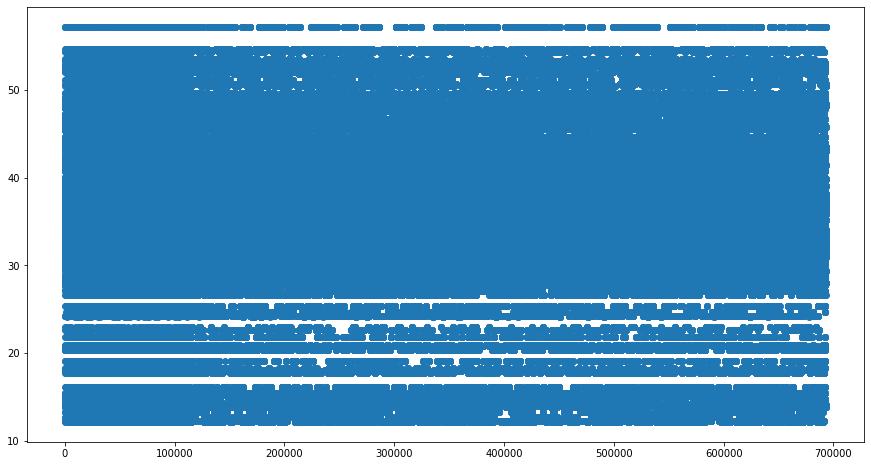

In [12]:
plt.figure(figsize=(15,8))
x = range(df.shape[0])
y = df.apparentTemperature
plt.scatter(x,y)

In [13]:
df['short_summary'].unique()

array([' Mostly Cloudy ', ' Rain ', ' Clear ', ' Partly Cloudy ',
       ' Overcast ', ' Light Rain ', ' Foggy ', ' Possible Drizzle ',
       ' Drizzle '], dtype=object)

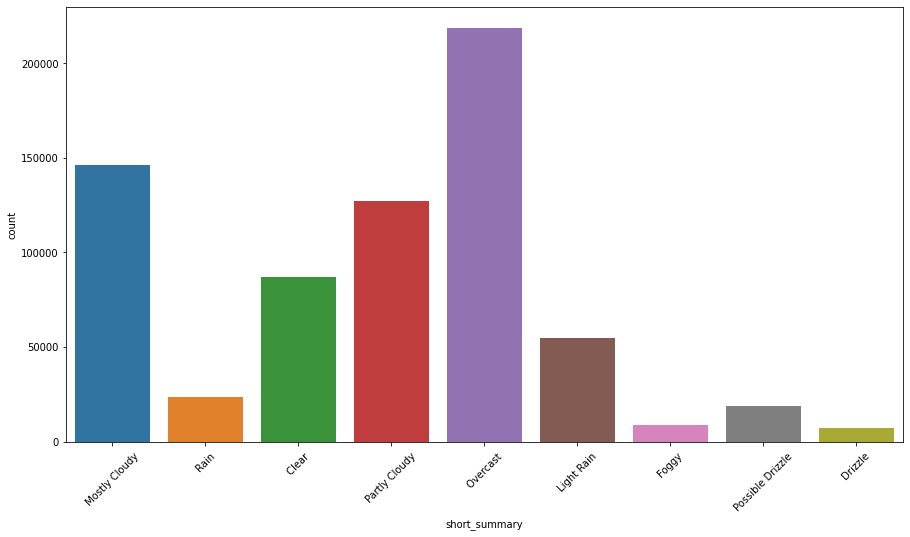

In [14]:
plt.figure(figsize=(15,8))
sns.countplot(df['short_summary'])
plt.xticks(rotation=45)
plt.show()

In [15]:
df['long_summary'].unique()

array([' Rain throughout the day. ',
       ' Rain until morning, starting again in the evening. ',
       ' Light rain in the morning. ',
       ' Partly cloudy throughout the day. ',
       ' Mostly cloudy throughout the day. ',
       ' Light rain in the morning and overnight. ',
       ' Light rain until evening. ', ' Foggy in the morning. ',
       ' Overcast throughout the day. ',
       ' Possible drizzle in the morning. ',
       ' Rain in the morning and afternoon. '], dtype=object)

In [16]:
words = stopwords.words('english')

In [17]:
pun = string.punctuation

In [18]:
def clean_text(x):
    x = [i for i in x if i not in pun]
    x = "".join(x)
    x = x.split(" ")
    w = [i for i in x if i not in words]
    w = [i for i in w if i != ""]
    return " ".join(w)

In [19]:
df['long_summary'] = df['long_summary'].apply(lambda x: clean_text(x))

In [20]:
df['long_summary'].unique()

array(['Rain throughout day', 'Rain morning starting evening',
       'Light rain morning', 'Partly cloudy throughout day',
       'Mostly cloudy throughout day', 'Light rain morning overnight',
       'Light rain evening', 'Foggy morning', 'Overcast throughout day',
       'Possible drizzle morning', 'Rain morning afternoon'], dtype=object)

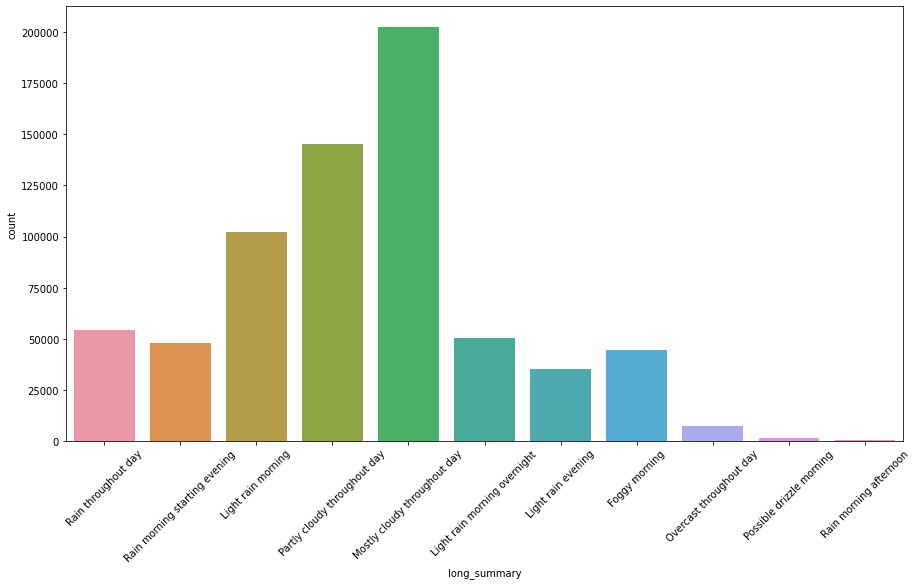

In [21]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.countplot(df['long_summary'])
plt.show()

In [22]:
df['timestamp']

0         1.544953e+09
1         1.543284e+09
2         1.543367e+09
3         1.543554e+09
4         1.543463e+09
              ...     
693066    1.543708e+09
693067    1.543708e+09
693068    1.543708e+09
693069    1.543708e+09
693070    1.543708e+09
Name: timestamp, Length: 693071, dtype: float64

In [23]:
df['temperatureHighTime']

0         1544968800
1         1543251600
2         1543320000
3         1543510800
4         1543420800
             ...    
693066    1543690800
693067    1543690800
693068    1543690800
693069    1543690800
693070    1543690800
Name: temperatureHighTime, Length: 693071, dtype: int64

In [24]:
df['timestamp'].iloc[0]-df['temperatureHighTime'].iloc[0]

-16192.109999895096

In [25]:
time_cols = ['windGustTime','temperatureHighTime','temperatureLowTime','apparentTemperatureHighTime',\
             'apparentTemperatureLowTime','uvIndexTime','temperatureMinTime','temperatureMaxTime',\
             'apparentTemperatureMinTime','apparentTemperatureMaxTime']

In [26]:
for col in time_cols:
    df[col+"_diff"] = df[col]-df['timestamp']

In [27]:
df = df.drop(columns=time_cols)

In [28]:
df['windGustTime_diff']

0         62992.110
1          7176.323
2        -32422.198
3        -39182.749
4        -17360.223
            ...    
693066   -35586.000
693067   -35586.000
693068   -35586.000
693069   -35586.000
693070   -35586.000
Name: windGustTime_diff, Length: 693071, dtype: float64

In [29]:
df['windGust']

0          9.17
1         11.98
2          7.33
3          5.28
4          9.14
          ...  
693066     2.87
693067     2.87
693068     2.87
693069     2.87
693070     2.87
Name: windGust, Length: 693071, dtype: float64

In [30]:
for col in time_cols:
    df[col+"_diff"] = df[col+"_diff"].apply(lambda x: abs(x))

In [31]:
interaction_cols = [i[:-4] for i in time_cols]

In [32]:
interaction_cols

['windGust',
 'temperatureHigh',
 'temperatureLow',
 'apparentTemperatureHigh',
 'apparentTemperatureLow',
 'uvIndex',
 'temperatureMin',
 'temperatureMax',
 'apparentTemperatureMin',
 'apparentTemperatureMax']

In [33]:
for col in interaction_cols:
    df[col] = df[col]*df[col+"Time_diff"]

In [34]:
df = df.drop(columns=[i+"_diff" for i in time_cols])

In [35]:
df.columns

Index(['id', 'timestamp', 'hour', 'day', 'month', 'datetime', 'timezone',
       'source', 'destination', 'cab_type', 'product_id', 'name', 'price',
       'distance', 'surge_multiplier', 'latitude', 'longitude', 'temperature',
       'apparentTemperature', 'short_summary', 'long_summary',
       'precipIntensity', 'precipProbability', 'humidity', 'windSpeed',
       'windGust', 'visibility', 'temperatureHigh', 'temperatureLow',
       'apparentTemperatureHigh', 'apparentTemperatureLow', 'icon', 'dewPoint',
       'pressure', 'windBearing', 'cloudCover', 'uvIndex', 'visibility.1',
       'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase', 'precipIntensityMax',
       'temperatureMin', 'temperatureMax', 'apparentTemperatureMin',
       'apparentTemperatureMax'],
      dtype='object')

In [36]:
#More columns to drop

In [37]:
cols = ['id','timestamp','datetime','source','destination','product_id']

In [38]:
for c in cols:
    print(df[c].iloc[0])

424553bb-7174-41ea-aeb4-fe06d4f4b9d7
1544952607.89
2018-12-16 09:30:07
Haymarket Square
North Station
lyft_line


In [39]:
df['source'].unique()

array(['Haymarket Square', 'Back Bay', 'North End', 'North Station',
       'Beacon Hill', 'Boston University', 'Fenway', 'South Station',
       'Theatre District', 'West End', 'Financial District',
       'Northeastern University'], dtype=object)

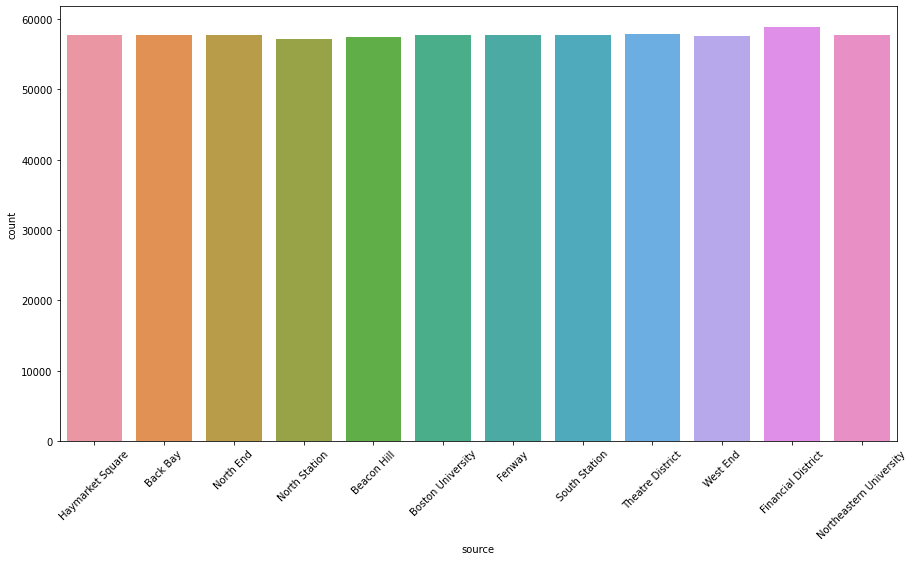

In [40]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.countplot(df['source'])
plt.show()

In [41]:
df['destination'].unique()

array(['North Station', 'Northeastern University', 'West End',
       'Haymarket Square', 'South Station', 'Fenway', 'Theatre District',
       'Beacon Hill', 'Back Bay', 'North End', 'Financial District',
       'Boston University'], dtype=object)

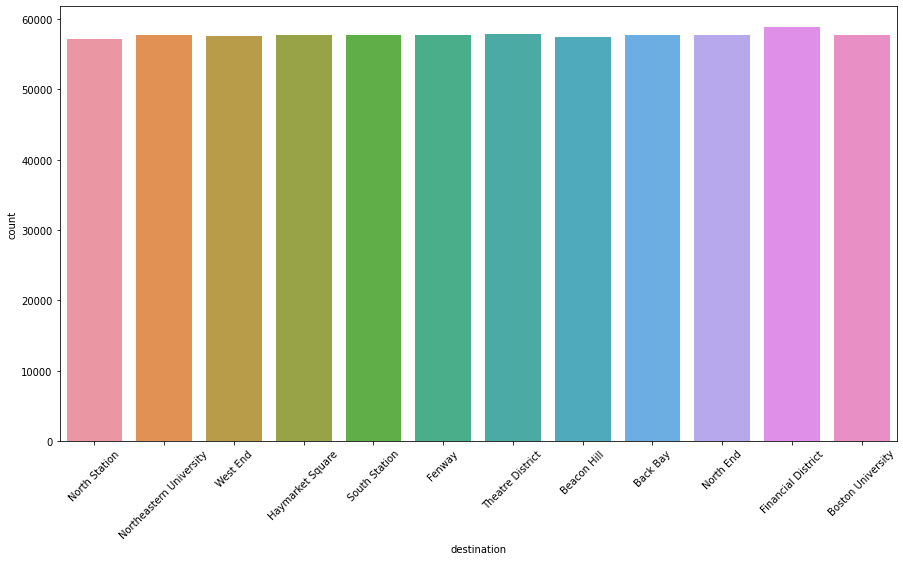

In [42]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.countplot(df['destination'])
plt.show()

In [43]:
print(len(set(df.source)))
print(len(set(df.destination)))
print(len(set(df.source).union(set(df.destination))))

12
12
12


In [44]:
set(df.source).difference(set(df.source))

set()

In [45]:
set(df.destination).difference(set(df.source))

set()

In [46]:
cols.remove('source')

In [47]:
cols.remove('destination')

In [48]:
df = df.drop(columns = cols)

In [49]:
df.columns

Index(['hour', 'day', 'month', 'timezone', 'source', 'destination', 'cab_type',
       'name', 'price', 'distance', 'surge_multiplier', 'latitude',
       'longitude', 'temperature', 'apparentTemperature', 'short_summary',
       'long_summary', 'precipIntensity', 'precipProbability', 'humidity',
       'windSpeed', 'windGust', 'visibility', 'temperatureHigh',
       'temperatureLow', 'apparentTemperatureHigh', 'apparentTemperatureLow',
       'icon', 'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility.1', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase',
       'precipIntensityMax', 'temperatureMin', 'temperatureMax',
       'apparentTemperatureMin', 'apparentTemperatureMax'],
      dtype='object')

In [50]:
df['timezone'].unique()

array(['America/New_York'], dtype=object)

In [51]:
df = df.drop(columns=['timezone'])

In [52]:
#'Apparent' columns

In [53]:
apparent_cols = []
for col in df.columns:
    if "apparent" in col:
        apparent_cols.append(col)

In [54]:
apparent_cols

['apparentTemperature',
 'apparentTemperatureHigh',
 'apparentTemperatureLow',
 'apparentTemperatureMin',
 'apparentTemperatureMax']

In [55]:
for col in apparent_cols:
    print("*"*50)
    print("{0} vs {1}".format(col,col[8:9].lower()+col[9:]))
    print(np.corrcoef(df[col],df[col[8:9].lower()+col[9:]])[0][1])

**************************************************
apparentTemperature vs temperature
0.9461664453752516
**************************************************
apparentTemperatureHigh vs temperatureHigh
0.9619954911787393
**************************************************
apparentTemperatureLow vs temperatureLow
0.9374804445873023
**************************************************
apparentTemperatureMin vs temperatureMin
0.6759317268555379
**************************************************
apparentTemperatureMax vs temperatureMax
0.9448577181618578


In [56]:
#Extremely high correlation except apparentTemperatureMin vs temperatureMin

In [57]:
apparent_cols.remove('apparentTemperatureMin')

In [58]:
df = df.drop(columns=apparent_cols)

In [59]:
df.columns

Index(['hour', 'day', 'month', 'source', 'destination', 'cab_type', 'name',
       'price', 'distance', 'surge_multiplier', 'latitude', 'longitude',
       'temperature', 'short_summary', 'long_summary', 'precipIntensity',
       'precipProbability', 'humidity', 'windSpeed', 'windGust', 'visibility',
       'temperatureHigh', 'temperatureLow', 'icon', 'dewPoint', 'pressure',
       'windBearing', 'cloudCover', 'uvIndex', 'visibility.1', 'ozone',
       'sunriseTime', 'sunsetTime', 'moonPhase', 'precipIntensityMax',
       'temperatureMin', 'temperatureMax', 'apparentTemperatureMin'],
      dtype='object')

In [60]:
#precipProbability vs humidity

In [61]:
np.corrcoef(df['precipProbability'],df['humidity'])[0][1]

0.5487658503905272

In [62]:
np.corrcoef(df['visibility'],df['visibility.1'])

array([[1., 1.],
       [1., 1.]])

In [63]:
df = df.drop(columns=['visibility.1'])

In [64]:
df.shape[1]

37

In [65]:
df.short_summary.unique()

array([' Mostly Cloudy ', ' Rain ', ' Clear ', ' Partly Cloudy ',
       ' Overcast ', ' Light Rain ', ' Foggy ', ' Possible Drizzle ',
       ' Drizzle '], dtype=object)

In [66]:
df.long_summary.unique()

array(['Rain throughout day', 'Rain morning starting evening',
       'Light rain morning', 'Partly cloudy throughout day',
       'Mostly cloudy throughout day', 'Light rain morning overnight',
       'Light rain evening', 'Foggy morning', 'Overcast throughout day',
       'Possible drizzle morning', 'Rain morning afternoon'], dtype=object)

In [67]:
df = df.drop(columns=['long_summary'])

In [68]:
cols = list(df.columns)

In [69]:
cols.remove('price')

In [70]:
#Correlation

In [71]:
df.shape[1]

36

In [72]:
df2 = pd.get_dummies(df)

In [73]:
df2.to_csv("Rideshare2_dummies.csv", index=False)

In [74]:
df2 = pd.read_csv("Rideshare2_dummies.csv")

In [75]:
tset = set()
for c in df2.columns:
    x = df2[c]
    cset = (type(i) for i in x)
    for i in cset:
        tset.add(i)

In [76]:
print(tset)

{<class 'int'>, <class 'float'>}


In [77]:
for col in df2.columns:
    df2[col] = df2[col].astype(float)

In [78]:
tset = set()
for c in df2.columns:
    x = df2[c]
    cset = (type(i) for i in x)
    for i in cset:
        tset.add(i)

In [79]:
print(tset)

{<class 'float'>}


In [80]:
df2.shape

(693071, 85)

In [81]:
df2.describe

<bound method NDFrame.describe of         hour   day  ...  icon_ partly-cloudy-night   icon_ rain 
0        9.0  16.0  ...                         1.0          0.0
1        2.0  27.0  ...                         0.0          1.0
2        1.0  28.0  ...                         0.0          0.0
3        4.0  30.0  ...                         0.0          0.0
4        3.0  29.0  ...                         1.0          0.0
...      ...   ...  ...                         ...          ...
693066  23.0   1.0  ...                         1.0          0.0
693067  23.0   1.0  ...                         1.0          0.0
693068  23.0   1.0  ...                         1.0          0.0
693069  23.0   1.0  ...                         1.0          0.0
693070  23.0   1.0  ...                         1.0          0.0

[693071 rows x 85 columns]>

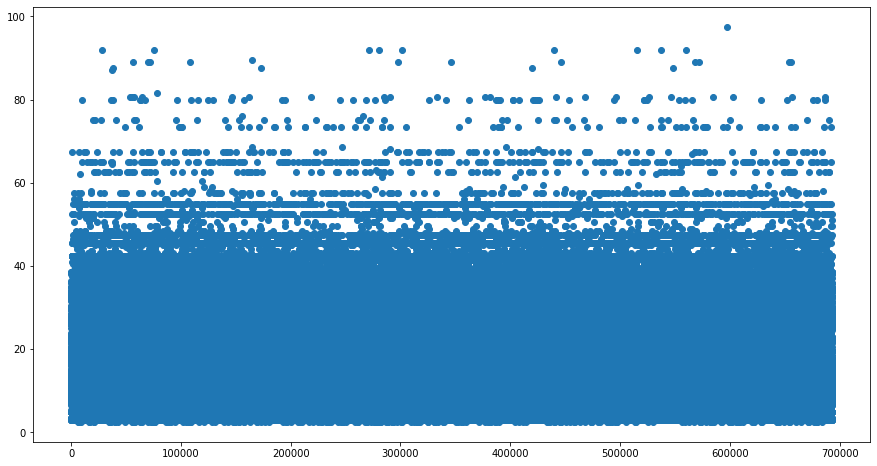

In [82]:
x = range(df2.shape[0])
y = df2.price
plt.figure(figsize=(15,8))
plt.scatter(x,y)
plt.show()

In [83]:
df2.price.describe()

count    637976.000000
mean         16.545125
std           9.324359
min           2.500000
25%           9.000000
50%          13.500000
75%          22.500000
max          97.500000
Name: price, dtype: float64

In [84]:
for col in df2.columns:
    print("{0}: {1}".format(col,df2[col].isna().sum()))

hour: 0
day: 0
month: 0
price: 55095
distance: 0
surge_multiplier: 0
latitude: 0
longitude: 0
temperature: 0
precipIntensity: 0
precipProbability: 0
humidity: 0
windSpeed: 0
windGust: 0
visibility: 0
temperatureHigh: 0
temperatureLow: 0
dewPoint: 0
pressure: 0
windBearing: 0
cloudCover: 0
uvIndex: 0
ozone: 0
sunriseTime: 0
sunsetTime: 0
moonPhase: 0
precipIntensityMax: 0
temperatureMin: 0
temperatureMax: 0
apparentTemperatureMin: 0
source_Back Bay: 0
source_Beacon Hill: 0
source_Boston University: 0
source_Fenway: 0
source_Financial District: 0
source_Haymarket Square: 0
source_North End: 0
source_North Station: 0
source_Northeastern University: 0
source_South Station: 0
source_Theatre District: 0
source_West End: 0
destination_Back Bay: 0
destination_Beacon Hill: 0
destination_Boston University: 0
destination_Fenway: 0
destination_Financial District: 0
destination_Haymarket Square: 0
destination_North End: 0
destination_North Station: 0
destination_Northeastern University: 0
destinati

In [85]:
for col in df2.columns:
    min_term = min(df2[col])
    max_term = max(df2[col])
    if max_term > 1 or min_term < -1:
        print("{0}: min: {1}, max: {2}".format(col,min_term,max_term))

hour: min: 0.0, max: 23.0
day: min: 1.0, max: 30.0
month: min: 11.0, max: 12.0
price: min: 2.5, max: 97.5
distance: min: 0.02, max: 7.86
surge_multiplier: min: 1.0, max: 3.0
latitude: min: 42.2148, max: 42.3661
longitude: min: -71.1054, max: -71.033
temperature: min: 18.91, max: 57.22
windSpeed: min: 0.45, max: 15.0
windGust: min: 15.44, max: 973926.72
visibility: min: 0.7170000000000001, max: 10.0
temperatureHigh: min: 131.88, max: 3100019.2
temperatureLow: min: 163.0, max: 4065219.18
dewPoint: min: 4.39, max: 50.67
pressure: min: 988.09, max: 1035.55
windBearing: min: 2.0, max: 356.0
uvIndex: min: 0.0, max: 14294.0
ozone: min: 269.4, max: 378.9
sunriseTime: min: 1543146535.0, max: 1545135001.0
sunsetTime: min: 1543180615.0, max: 1545167693.0
temperatureMin: min: 22.22, max: 3538785.92
temperatureMax: min: 135.32, max: 3100019.2
apparentTemperatureMin: min: 17.83, max: 3276041.6


In [86]:
#Potential columns for scaling

In [87]:
potential_scale_columns = ['windGust','visibility','temperatureHigh','temperatureLow','dewPoint','pressure',\
                          'windBearing','uvIndex','ozone','sunriseTime','sunsetTime','temperatureMin',\
                           'temperatureMax','apparentTemperatureMin']

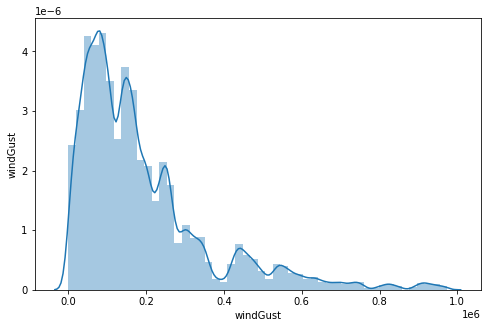

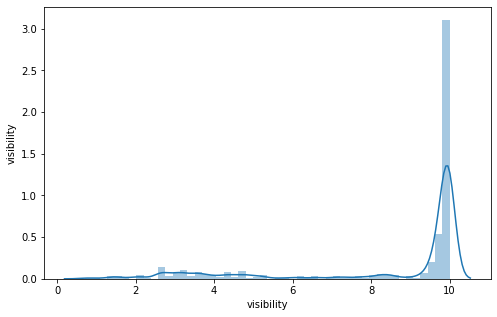

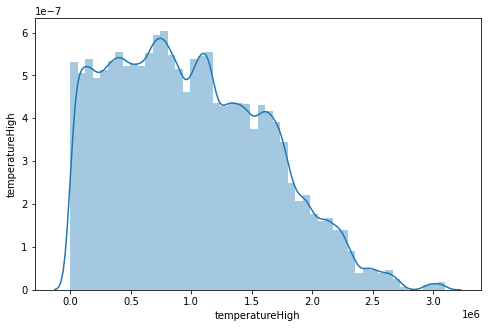

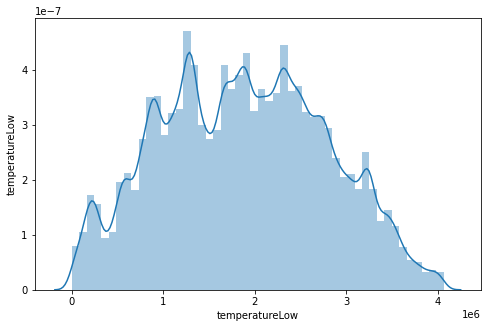

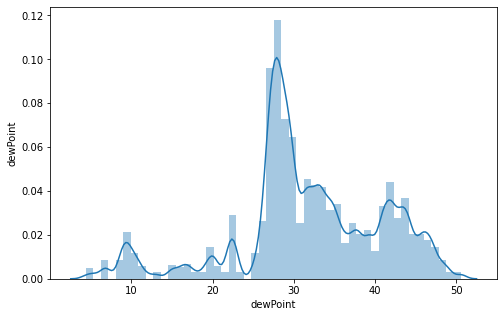

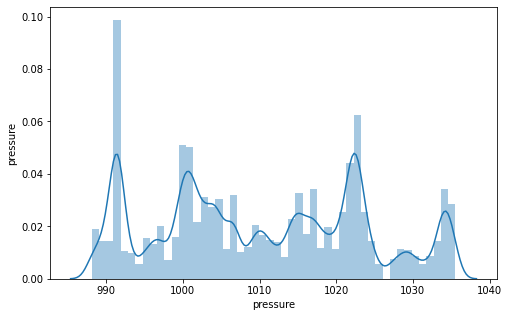

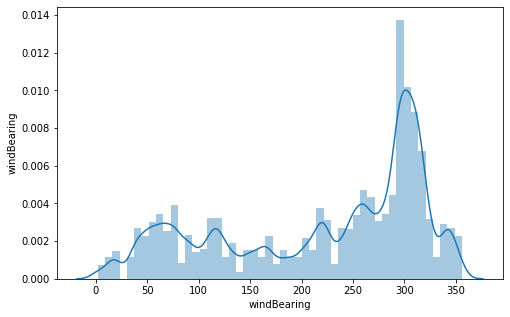

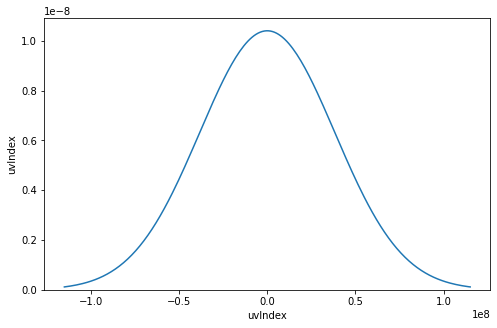

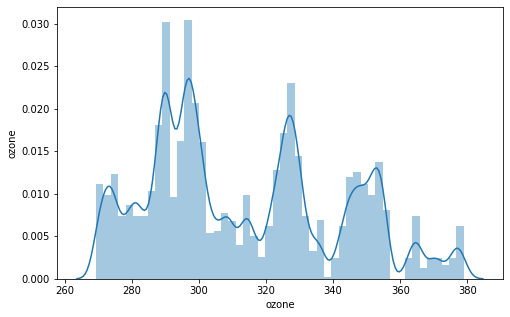

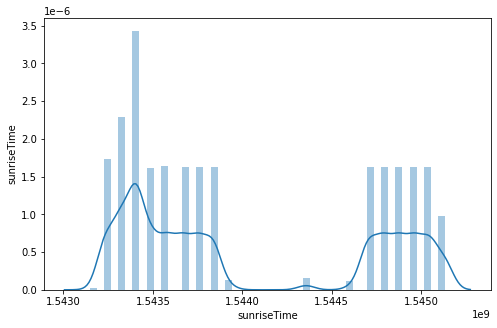

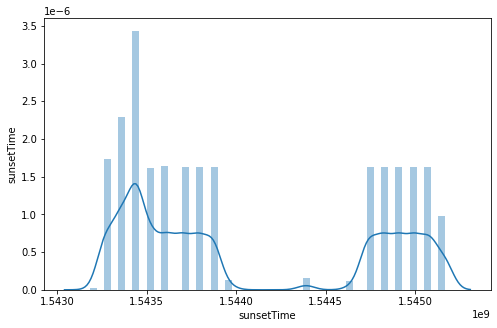

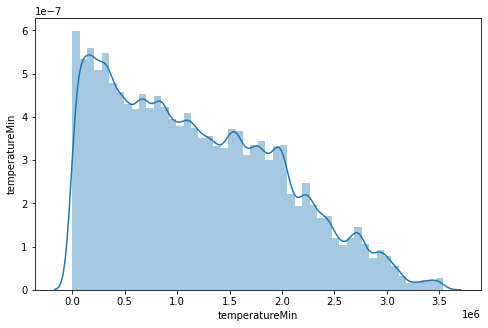

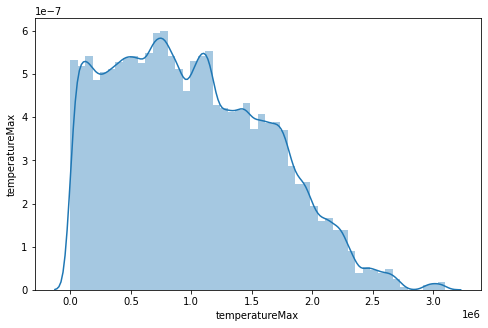

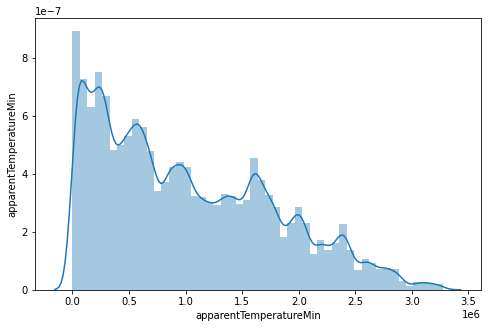

In [88]:
for col in potential_scale_columns:
    plt.figure(figsize=(8,5))
    if col == 'uvIndex':
        sns.kdeplot(df2[col], bw = 14294.0)
    else:
        sns.distplot(df2[col])
    plt.ylabel(col)
    plt.show()

In [89]:
MinMaxScaler = skp.MinMaxScaler()

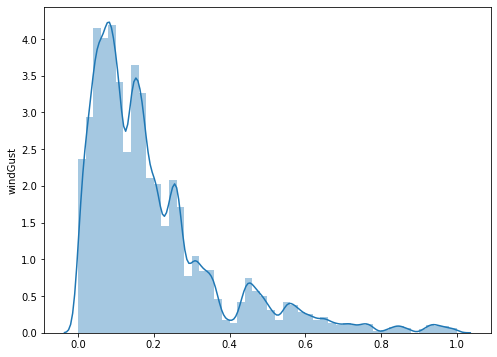

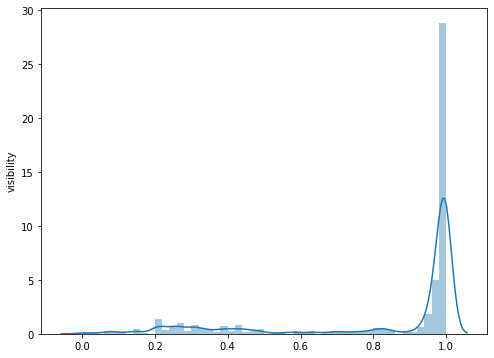

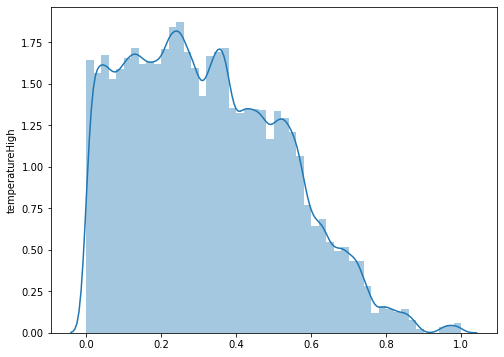

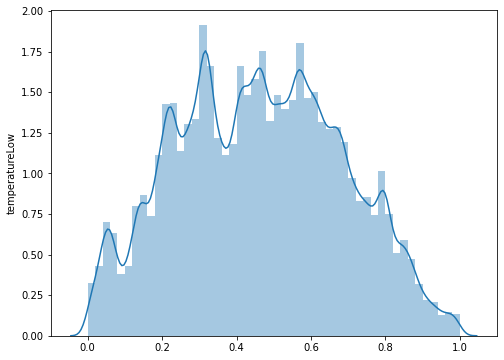

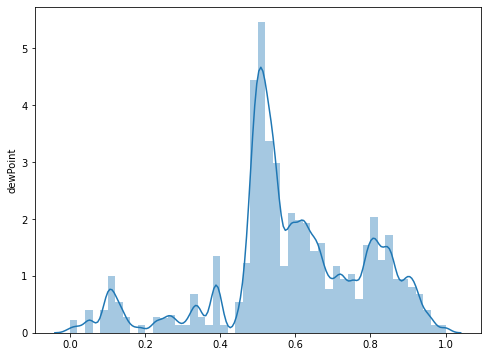

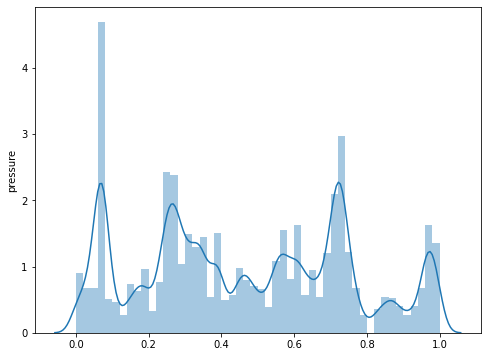

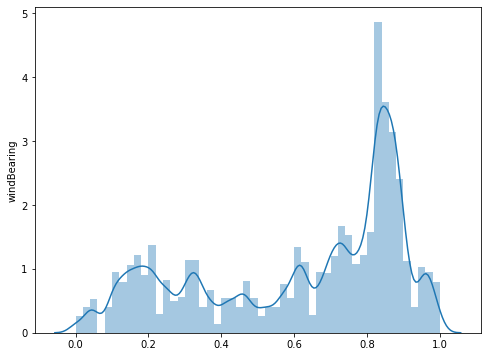

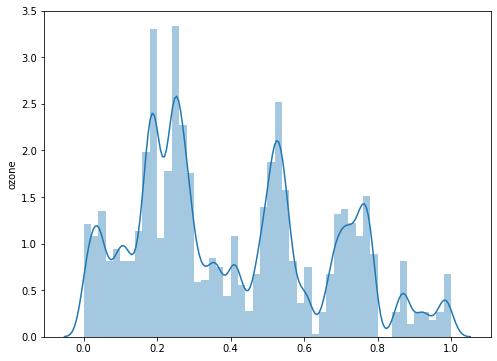

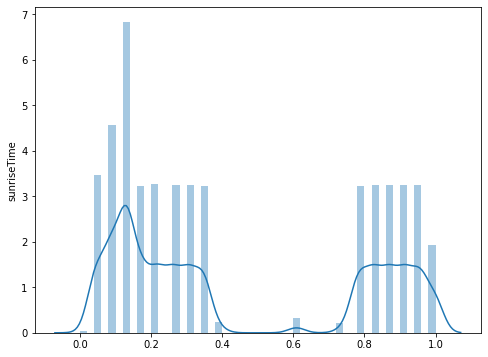

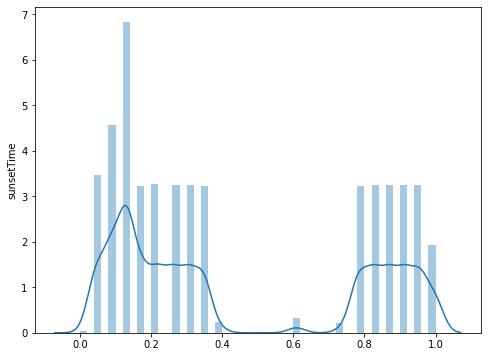

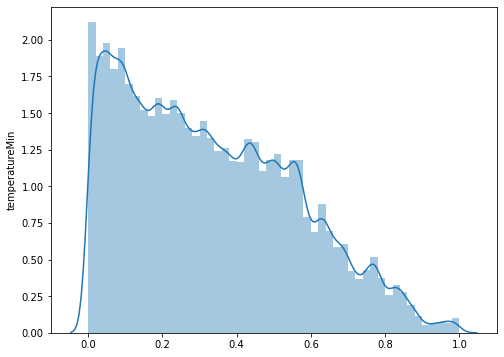

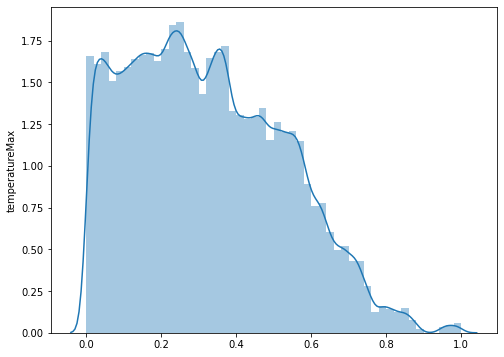

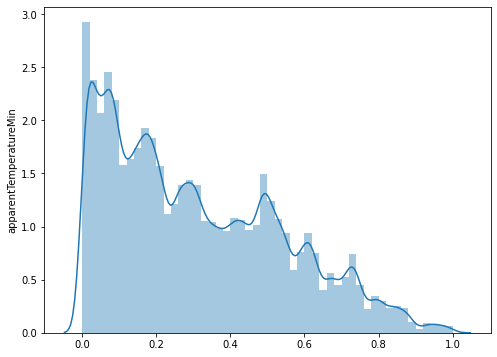

In [90]:
for col in potential_scale_columns:
    if col == 'uvIndex':
        continue
    x = np.array(df2[col]).reshape((-1,1))
    mmx = MinMaxScaler.fit_transform(x)
    plt.figure(figsize=(8,6))
    sns.distplot(mmx)
    plt.ylabel(col)
    plt.show()

In [91]:
StandardScaler = skp.StandardScaler()

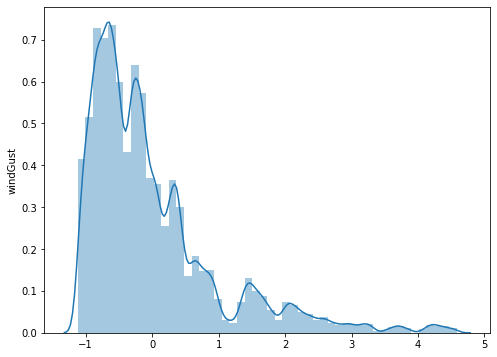

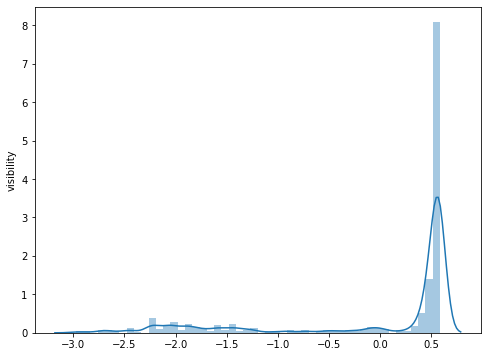

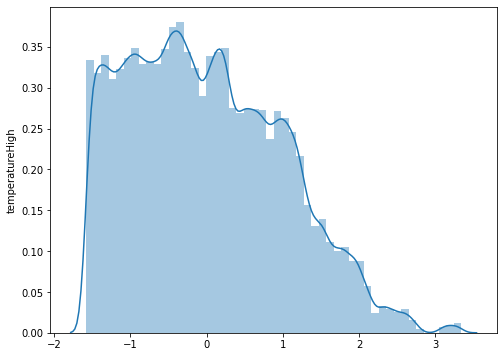

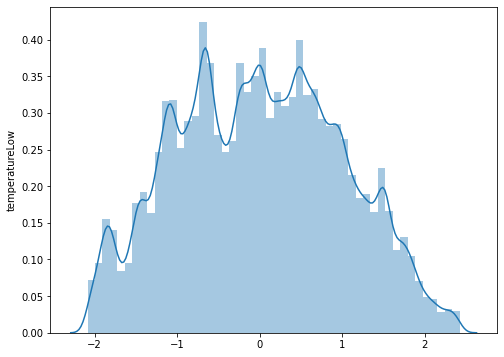

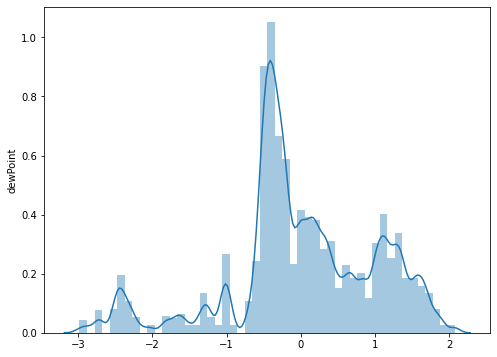

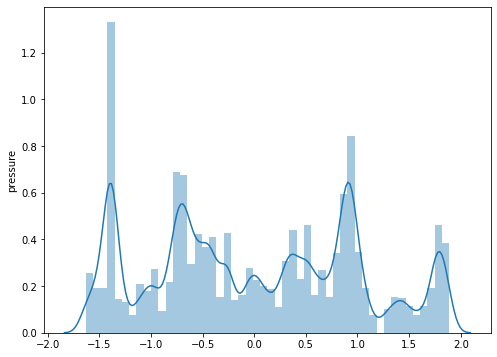

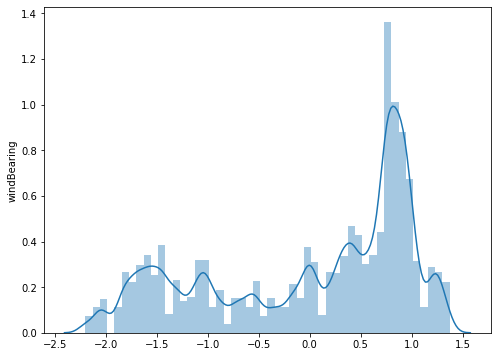

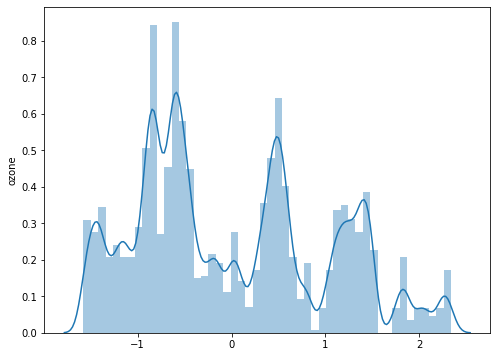

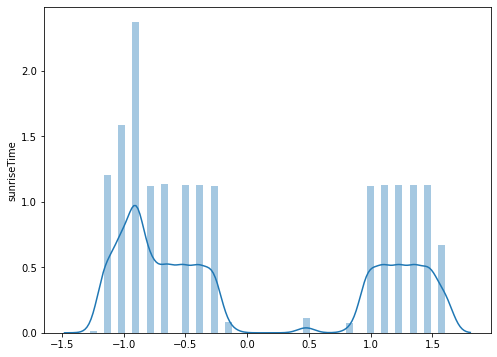

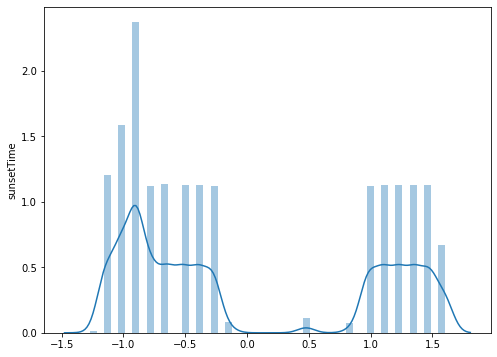

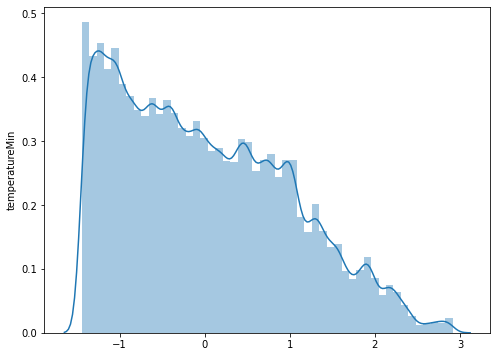

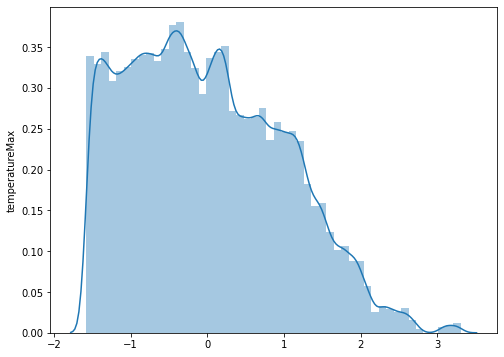

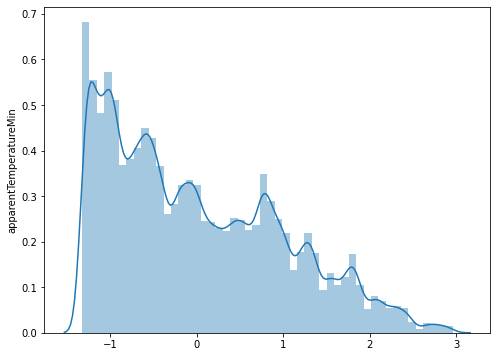

In [92]:
for col in potential_scale_columns:
    if col == 'uvIndex':
        continue
    x = np.array(df2[col]).reshape((-1,1))
    mmx = StandardScaler.fit_transform(x)
    plt.figure(figsize=(8,6))
    sns.distplot(mmx)
    plt.ylabel(col)
    plt.show()

In [93]:
#MinMaxScaler

In [94]:
potential_scale_columns

['windGust',
 'visibility',
 'temperatureHigh',
 'temperatureLow',
 'dewPoint',
 'pressure',
 'windBearing',
 'uvIndex',
 'ozone',
 'sunriseTime',
 'sunsetTime',
 'temperatureMin',
 'temperatureMax',
 'apparentTemperatureMin']

In [95]:
minmaxcols = ['pressure','windBearing','ozone','sunriseTime','sunsetTime','apparentTemperatureMin']

In [96]:
for col in minmaxcols:
    mms = skp.MinMaxScaler()
    df2[col] = mms.fit_transform(np.array(df2[col]).reshape((-1,1)))

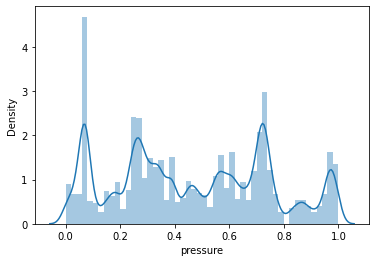

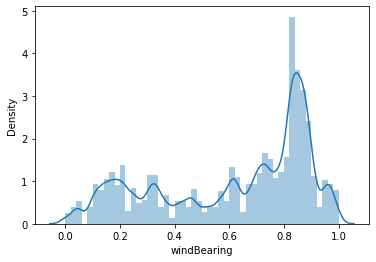

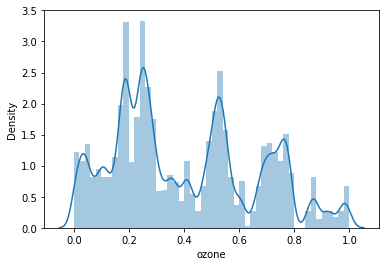

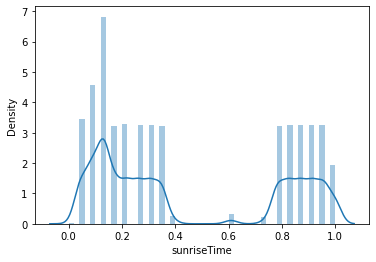

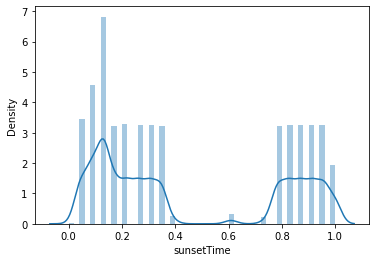

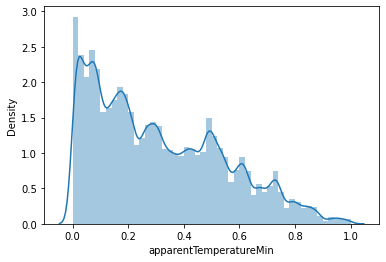

In [97]:
for col in minmaxcols:
    plt.figure()
    sns.distplot(df2[col])
    plt.show()

In [98]:
for col in minmaxcols:
    print(df2[col].describe())
    print("\n")

count    693071.000000
mean          0.463649
std           0.283879
min           0.000000
25%           0.247155
50%           0.445849
75%           0.711547
max           1.000000
Name: pressure, dtype: float64


count    693071.000000
mean          0.615977
std           0.279951
min           0.000000
25%           0.344633
50%           0.723164
75%           0.850282
max           1.000000
Name: windBearing, dtype: float64


count    693071.000000
mean          0.402864
std           0.255279
min           0.000000
25%           0.196347
50%           0.347032
75%           0.569863
max           1.000000
Name: ozone, dtype: float64


count    693071.000000
mean          0.442835
std           0.347574
min           0.000000
25%           0.130454
50%           0.304368
75%           0.826116
max           1.000000
Name: sunriseTime, dtype: float64


count    693071.000000
mean          0.442773
std           0.347577
min           0.000000
25%           0.130395
50%           

In [99]:
#StandardScaler

In [100]:
standardcols = [col for col in potential_scale_columns if col not in minmaxcols]

In [101]:
standardcols.remove('uvIndex')

In [102]:
for col in standardcols:
    ss = skp.StandardScaler()
    df2[col] = ss.fit_transform(np.array(df2[col]).reshape((-1,1)))

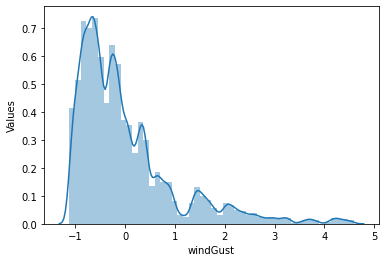

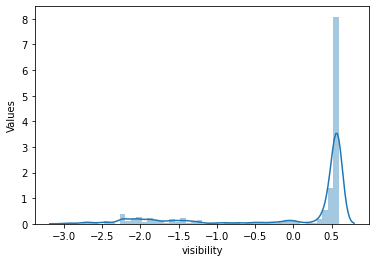

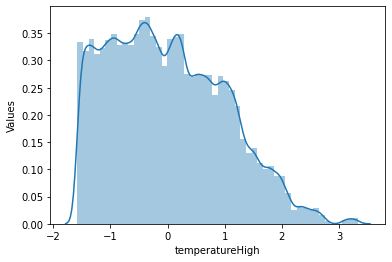

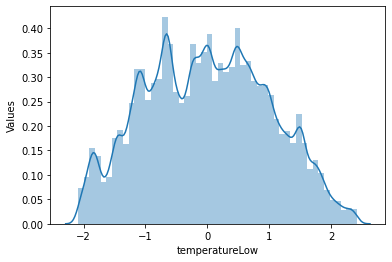

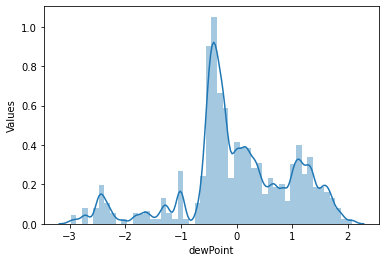

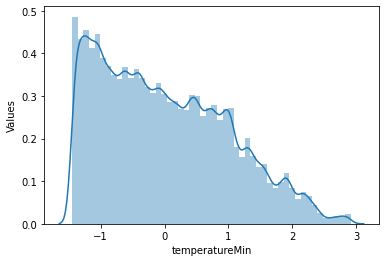

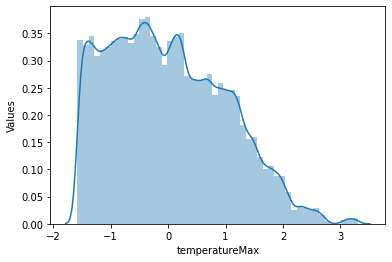

In [103]:
for col in standardcols:
    plt.figure()
    sns.distplot(df2[col])
    plt.ylabel("Values")
    plt.show()

In [104]:
for col in standardcols:
    print(df2[col].describe())
    print("\n")

count    6.930710e+05
mean     9.776651e-18
std      1.000001e+00
min     -1.117049e+00
25%     -6.825982e-01
50%     -2.757433e-01
75%      3.372320e-01
max      4.582198e+00
Name: windGust, dtype: float64


count    6.930710e+05
mean    -1.686065e-15
std      1.000001e+00
min     -2.977837e+00
25%     -1.381945e-02
50%      5.424861e-01
75%      5.870520e-01
max      5.885887e-01
Name: visibility, dtype: float64


count    6.930710e+05
mean    -5.600141e-17
std      1.000001e+00
min     -1.580794e+00
25%     -8.261309e-01
50%     -1.015604e-01
75%      7.297113e-01
max      3.340529e+00
Name: temperatureHigh, dtype: float64


count    6.930710e+05
mean    -8.110731e-16
std      1.000001e+00
min     -2.087009e+00
25%     -7.707649e-01
50%     -3.495732e-03
75%      7.414806e-01
max      2.426702e+00
Name: temperatureLow, dtype: float64


count    6.930710e+05
mean     4.542806e-16
std      1.000001e+00
min     -2.982413e+00
25%     -4.557096e-01
50%     -1.056901e-01
75%      7.070113

In [105]:
#Treating NaN values

In [106]:
df2 = df2[df2.price.isna() == False]

In [107]:
#Data Separation

In [108]:
y = df2['price']
X = df2.drop(columns=['price'])

In [109]:
print(df2.shape)
print(y.shape)
print(X.shape)

(637976, 85)
(637976,)
(637976, 84)


In [110]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [111]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(510380, 84)
(127596, 84)
(510380,)
(127596,)


## Models

In [112]:
models = []
mses = []

In [113]:
#Linear Regression Model

In [114]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)

In [115]:
lr.coef_

array([ 1.44396935e-03,  3.39385788e-02,  1.04573288e+00,  2.88973971e+00,
        1.83948224e+01,  2.43836289e-01,  1.77075310e-01, -6.92240525e-03,
       -9.57575134e-02,  3.77275749e-02, -3.66197747e-01,  7.78123905e-04,
        2.77376223e-04, -1.30860127e-02, -2.18275402e-02,  1.41929271e-02,
        8.01923852e-02,  6.16876458e-02,  5.25102173e-02, -1.17316474e-01,
       -4.73252906e-06,  1.11202953e-02, -3.29581378e+02,  3.28752031e+02,
        1.85239344e-02,  7.38196595e-03, -2.01462854e-03,  1.97861096e-02,
       -6.53822797e-03, -1.41694220e-01, -4.48925120e-01, -3.28865653e-01,
       -1.35100559e-01,  2.15108019e-01,  3.31789658e-01,  4.96070242e-01,
       -6.38223030e-02, -3.62516263e-01,  1.34324877e-01,  3.77314612e-01,
       -7.36832898e-02, -5.89052060e-02, -3.74076919e-01, -1.47827889e-02,
       -3.38574030e-01,  3.45759648e-01,  2.04619559e-01,  5.62015727e-02,
        1.40439762e-01,  2.71568831e-03, -4.58823019e-02,  1.74751405e-01,
       -9.22663884e-02,  

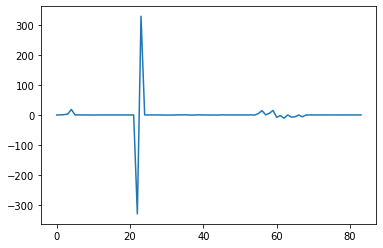

In [116]:
plt.plot(lr.coef_)

In [117]:
feautures = X_train.columns
coef = lr.coef_
reg = pd.DataFrame({'Feature':feautures,'Coefficients':coef})

In [118]:
poly = reg[reg.Coefficients > 1]

In [119]:
non_important = reg[abs(reg.Coefficients) < 0.09].Feature

In [120]:
y_true = y_test

In [121]:
y_pred = lr.predict(X_test)

In [122]:
explained_variance = metrics.explained_variance_score(y_true, y_pred)
mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred) 
mse = metrics.mean_squared_error(y_true, y_pred) 
mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
r2 = metrics.r2_score(y_true, y_pred)

print('explained_variance: ', round(explained_variance,4))    
print('mean_squared_log_error: ', round(mean_squared_log_error,4))
print('r2: ', round(r2,4))
print('MAE: ', round(mean_absolute_error,4))
print('MSE: ', round(mse,4))
print('RMSE: ', round(np.sqrt(mse),4))

explained_variance:  0.9295
mean_squared_log_error:  0.0296
r2:  0.9295
MAE:  1.74
MSE:  6.0642
RMSE:  2.4626


In [123]:
models.append('Linear Regression')
mses.append(round(mse,4))

### Reducing the size of Dataset


In [124]:
df2 = df2.drop(columns=non_important)

In [125]:
df2 = shuffle(df2)[:10000]

In [126]:
y = df2['price']
X = df2.drop(columns=['price'])

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [128]:
print(X_train.shape)
print(X_test.shape)

(8000, 41)
(2000, 41)


In [129]:
### Choosing the best models from project 1
#1. Decision tree with maximum depth 8
#2. Lasso regression with alpha 0.01

Bagging regressor

In [130]:
n_est = [1,2,5,10,25]

In [131]:
best_score, best_n = float('inf'),-1
for n in n_est:
  dt_bag_regressor = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),n_estimators=n,random_state=0)
  dt_bag_regressor = dt_bag_regressor.fit(X_train,y_train)
  y_pred = dt_bag_regressor.predict(X_test)
  score = metrics.mean_squared_error(y_test,y_pred)
  print(score)
  if score < best_score:
    best_score = score
    best_n = n
print(best_score,best_n)

6.917070922288904
6.004073109582125
5.532752138310535
5.343666725479454
5.203199473752602
5.203199473752602 25


In [132]:
models.append("DT_maxdepth_8_nest_{}_bagging".format(best_n))
mses.append(best_score)

In [133]:
best_score, best_n = float('inf'),-1
for n in n_est:
  lasso_bag_regressor = BaggingRegressor(base_estimator=Lasso(alpha=0.01),n_estimators=n,random_state=0)
  lasso_bag_regressor = lasso_bag_regressor.fit(X_train,y_train)
  y_pred = lasso_bag_regressor.predict(X_test)
  score = metrics.mean_squared_error(y_test,y_pred)
  print(score)
  if score < best_score:
    best_score = score
    best_n = n
print(best_score,best_n)

6.529498307027652
6.534422909170248
6.50453654214275
6.5028378601209225
6.49965397617634
6.49965397617634 25


In [134]:
models.append("Lasso_alpha_0.01_nest_{}_bagging".format(best_n))
mses.append(best_score)

Pasting

In [135]:
best_score, best_n = float('inf'),-1
for n in n_est:
  dt_bag_regressor = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),n_estimators=n,random_state=0,bootstrap=False)
  dt_bag_regressor = dt_bag_regressor.fit(X_train,y_train)
  y_pred = dt_bag_regressor.predict(X_test)
  score = metrics.mean_squared_error(y_test,y_pred)
  print(score)
  if score < best_score:
    best_score = score
    best_n = n
print(best_score,best_n)

6.29079581316152
6.243858313161519
6.122059730251494
6.027401631050465
6.060690148682395
6.027401631050465 10


In [136]:
models.append("DT_maxdepth_8_nest_{}_pasting".format(best_n))
mses.append(best_score)

In [137]:
best_score, best_n = float('inf'),-1
for n in n_est:
  lasso_bag_regressor = BaggingRegressor(base_estimator=Lasso(alpha=0.01),n_estimators=n,random_state=0,bootstrap=False)
  lasso_bag_regressor = lasso_bag_regressor.fit(X_train,y_train)
  y_pred = lasso_bag_regressor.predict(X_test)
  score = metrics.mean_squared_error(y_test,y_pred)
  print(score)
  if score < best_score:
    best_score = score
    best_n = n
print(best_score,best_n)

6.504602552114726
6.504602552114726
6.504602552114726
6.504602552114727
6.504602552114726
6.504602552114726 1


In [138]:
models.append("Lasso_alpha_0.01_nest_{}_pasting".format(best_n))
mses.append(best_score)

Adaboost

In [139]:
best_score, best_n = float('inf'),-1
for n in n_est:
  dt_bag_regressor = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),n_estimators=n,random_state=0)
  dt_bag_regressor = dt_bag_regressor.fit(X_train,y_train)
  y_pred = dt_bag_regressor.predict(X_test)
  score = metrics.mean_squared_error(y_test,y_pred)
  print(score)
  if score < best_score:
    best_score = score
    best_n = n
print(best_score,best_n)

6.703386432164025
6.703386432164025
6.053762068401768
5.522464695087446
6.061931168725195
5.522464695087446 10


In [140]:
models.append("DT_maxdepth_8_nest_{}_Adaboost".format(best_n))
mses.append(best_score)

In [141]:
best_score, best_n = float('inf'),-1
for n in n_est:
  lasso_bag_regressor = AdaBoostRegressor(base_estimator=Lasso(alpha=0.01),n_estimators=n,random_state=0)
  lasso_bag_regressor = lasso_bag_regressor.fit(X_train,y_train)
  y_pred = lasso_bag_regressor.predict(X_test)
  score = metrics.mean_squared_error(y_test,y_pred)
  print(score)
  if score < best_score:
    best_score = score
    best_n = n
print(best_score,best_n)

6.541943237971346
6.541943237971346
6.827491284832373
6.818737681940543
6.8212993725221835
6.541943237971346 1


In [142]:
models.append("Lasso_alpha_0.01_nest_{}_adaboost".format(best_n))
mses.append(best_score)

GradientBoosting

In [143]:
best_score, best_n = float('inf'),-1
for n in n_est:
  gb_regressor = GradientBoostingRegressor(n_estimators=n,random_state=0)
  gb_regressor = gb_regressor.fit(X_train,y_train)
  y_pred = gb_regressor.predict(X_test)
  score = metrics.mean_squared_error(y_test,y_pred)
  print(score)
  if score < best_score:
    best_score = score
    best_n = n
print(best_score,best_n)

76.35298947007861
67.85098633337063
50.20924605320035
34.59565316634759
15.966625364782008
15.966625364782008 25


In [144]:
models.append("GradientBoosting_n_est_{}".format(best_n))
mses.append(best_score)

PCA

In [145]:
pca = PCA(0.95)

In [146]:
X_train1 = pca.fit_transform(X_train)
X_test1 = pca.transform(X_test)

In [147]:
pca.n_components_

27

In [148]:
#Decision Tree
best_score, best_n = float('inf'),-1
for n in n_est:
  dt_bag_regressor = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),n_estimators=n,random_state=0)
  dt_bag_regressor = dt_bag_regressor.fit(X_train1,y_train)
  y_pred = dt_bag_regressor.predict(X_test1)
  score = metrics.mean_squared_error(y_test,y_pred)
  print(score)
  if score < best_score:
    best_score = score
    best_n = n
print(best_score,best_n)
models.append("DT_maxdepth_8_nest_{}_bagging_pca".format(best_n))
mses.append(best_score)

17.081920664909994
13.485909112072655
11.276626187615424
10.78349111500722
10.731576429726521
10.731576429726521 25


In [149]:
#Lasso
best_score, best_n = float('inf'),-1
for n in n_est:
  lasso_bag_regressor = BaggingRegressor(base_estimator=Lasso(alpha=0.01),n_estimators=n,random_state=0)
  lasso_bag_regressor = lasso_bag_regressor.fit(X_train,y_train)
  y_pred = lasso_bag_regressor.predict(X_test)
  score = metrics.mean_squared_error(y_test,y_pred)
  print(score)
  if score < best_score:
    best_score = score
    best_n = n
print(best_score,best_n)
models.append("Lasso_alpha_0.01_nest_{}_bagging_pca".format(best_n))
mses.append(best_score)

6.529498307027652
6.534422909170248
6.50453654214275
6.5028378601209225
6.49965397617634
6.49965397617634 25


In [150]:
#Pasting Decision Tree
best_score, best_n = float('inf'),-1
for n in n_est:
  dt_bag_regressor = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),n_estimators=n,random_state=0,bootstrap=False)
  dt_bag_regressor = dt_bag_regressor.fit(X_train,y_train)
  y_pred = dt_bag_regressor.predict(X_test)
  score = metrics.mean_squared_error(y_test,y_pred)
  print(score)
  if score < best_score:
    best_score = score
    best_n = n
print(best_score,best_n)
models.append("DT_maxdepth_8_nest_{}_pasting_pca".format(best_n))
mses.append(best_score)

6.29079581316152
6.243858313161519
6.122059730251494
6.027401631050465
6.060690148682395
6.027401631050465 10


In [151]:
#Pasting Lasso
best_score, best_n = float('inf'),-1
for n in n_est:
  lasso_bag_regressor = BaggingRegressor(base_estimator=Lasso(alpha=0.01),n_estimators=n,random_state=0,bootstrap=False)
  lasso_bag_regressor = lasso_bag_regressor.fit(X_train,y_train)
  y_pred = lasso_bag_regressor.predict(X_test)
  score = metrics.mean_squared_error(y_test,y_pred)
  print(score)
  if score < best_score:
    best_score = score
    best_n = n
print(best_score,best_n)
models.append("Lasso_alpha_0.01_nest_{}_pasting_pca".format(best_n))
mses.append(best_score)

6.504602552114726
6.504602552114726
6.504602552114726
6.504602552114727
6.504602552114726
6.504602552114726 1


In [152]:
#Adaboost Decision Tree
best_score, best_n = float('inf'),-1
for n in n_est:
  dt_bag_regressor = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8),n_estimators=n,random_state=0)
  dt_bag_regressor = dt_bag_regressor.fit(X_train,y_train)
  y_pred = dt_bag_regressor.predict(X_test)
  score = metrics.mean_squared_error(y_test,y_pred)
  print(score)
  if score < best_score:
    best_score = score
    best_n = n
print(best_score,best_n)
models.append("DT_maxdepth_8_nest_{}_Adaboost_pca".format(best_n))
mses.append(best_score)

6.703386432164025
6.703386432164025
6.053762068401768
5.522464695087446
6.061931168725195
5.522464695087446 10


In [153]:
#Adaboost Lasso
best_score, best_n = float('inf'),-1
for n in n_est:
  lasso_bag_regressor = AdaBoostRegressor(base_estimator=Lasso(alpha=0.01),n_estimators=n,random_state=0)
  lasso_bag_regressor = lasso_bag_regressor.fit(X_train,y_train)
  y_pred = lasso_bag_regressor.predict(X_test)
  score = metrics.mean_squared_error(y_test,y_pred)
  print(score)
  if score < best_score:
    best_score = score
    best_n = n
print(best_score,best_n)
models.append("Lasso_alpha_0.01_nest_{}_adaboost_pca".format(best_n))
mses.append(best_score)

6.541943237971346
6.541943237971346
6.827491284832373
6.818737681940543
6.8212993725221835
6.541943237971346 1


In [154]:
#Gradientboosting 
best_score, best_n = float('inf'),-1
for n in n_est:
  gb_regressor = GradientBoostingRegressor(n_estimators=n,random_state=0)
  gb_regressor = gb_regressor.fit(X_train,y_train)
  y_pred = gb_regressor.predict(X_test)
  score = metrics.mean_squared_error(y_test,y_pred)
  print(score)
  if score < best_score:
    best_score = score
    best_n = n
print(best_score,best_n)
models.append("GradientBoosting_n_est_{}_pca".format(best_n))
mses.append(best_score)

76.35298947007861
67.85098633337063
50.20924605320035
34.59565316634759
15.966625364782008
15.966625364782008 25


MLP Regressor

In [155]:
param = {'activation':['tanh', 'relu'],'solver':['lbfgs', 'sgd', 'adam'],'alpha':[0.001,0.01,0.1]}

In [156]:
mlp = GridSearchCV(estimator=MLPRegressor(random_state=0,early_stopping=True),param_grid=param)

In [157]:
warnings.simplefilter("ignore")
mlp_regressor = mlp.fit(X_train,y_train)
y_pred = mlp_regressor.predict(X_test)
score = metrics.mean_squared_error(y_test,y_pred)
print(mlp_regressor.best_params_)
models.append("MLP")
mses.append(score)

{'activation': 'tanh', 'alpha': 0.001, 'solver': 'adam'}


In [158]:
warnings.simplefilter("ignore")
mlp_regressor_pca = mlp.fit(X_train1,y_train)
y_pred = mlp_regressor_pca.predict(X_test1)
score = metrics.mean_squared_error(y_test,y_pred)
print(mlp_regressor_pca.best_params_)
models.append("MLP_pca")
mses.append(score)

{'activation': 'relu', 'alpha': 0.01, 'solver': 'lbfgs'}


### Comparing models

In [159]:
m_df = pd.DataFrame({'model':models,'mses':mses})

In [160]:
m_df

,model,mses
0,Linear Regression,6.064200
1,DT_maxdepth_8_nest_25_bagging,5.203199
2,Lasso_alpha_0.01_nest_25_bagging,6.499654
3,DT_maxdepth_8_nest_10_pasting,6.027402
4,Lasso_alpha_0.01_nest_1_pasting,6.504603
5,DT_maxdepth_8_nest_10_Adaboost,5.522465
6,Lasso_alpha_0.01_nest_1_adaboost,6.541943
7,GradientBoosting_n_est_25,15.966625
8,DT_maxdepth_8_nest_25_bagging_pca,10.731576
9,Lasso_alpha_0.01_nest_25_bagging_pca,6.499654


No handles with labels found to put in legend.


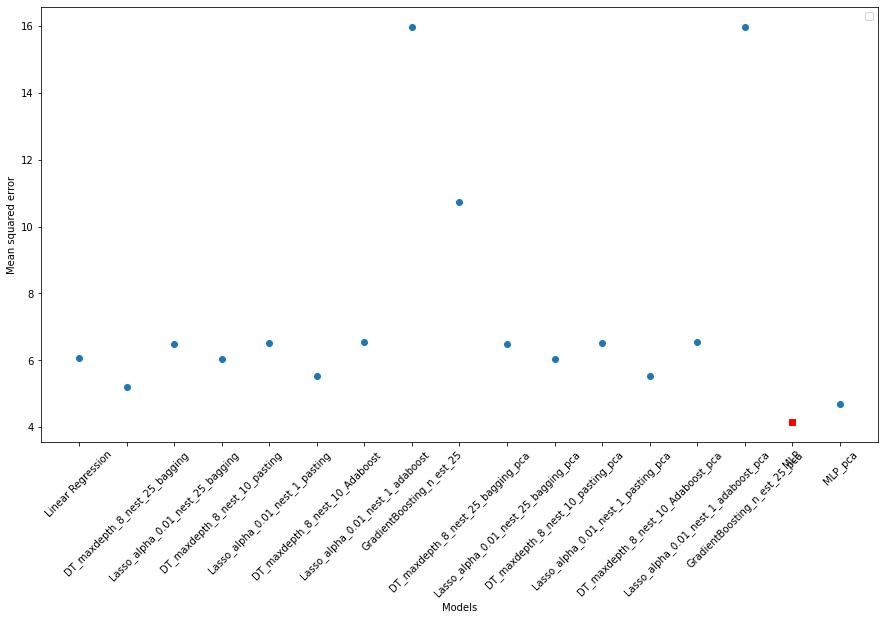

In [161]:
plt.figure(figsize=(15,8))
plt.scatter(m_df.model, m_df.mses)
plt.xlabel("Models")
plt.ylabel("Mean squared error")
plt.xticks(rotation=45)
plt.plot(m_df[m_df.mses == min(m_df.mses)].model,min(m_df.mses),'rs')
plt.legend()
plt.show()

In [162]:
m_df[m_df.mses == min(m_df.mses)]

,model,mses
15,MLP,4.153112
